# Import

In [1]:
import numpy as np
from sklearn.metrics import roc_curve
from sklearn.neighbors import KNeighborsClassifier
import random
import matplotlib.patheffects as PathEffects

In [2]:
from tensorflow.keras.layers import Input, Conv2D, Lambda, Dense, Flatten,MaxPooling2D, concatenate, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.losses import binary_crossentropy
import os
import pickle
import matplotlib.pyplot as plt

In [3]:
from itertools import permutations
import seaborn as sns
from keras.datasets import mnist
from sklearn.manifold import TSNE
from sklearn.svm import SVC

# Load Data

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


# Dataset Embbeding Visualize

In [5]:
# Define our own plot function
def scatter(x, labels, subtitle=None):
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))

    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40,
                    c=palette[labels.astype(np.int)])
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    # We add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[labels == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([
            PathEffects.Stroke(linewidth=5, foreground="w"),
            PathEffects.Normal()])
        txts.append(txt)
        
    if subtitle != None:
        plt.suptitle(subtitle)
        
    plt.savefig(subtitle)

In [6]:
x_train_flat = x_train.reshape(-1,784)
x_test_flat = x_test.reshape(-1,784)
x_test_flat.shape, x_train_flat.shape

((10000, 784), (60000, 784))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


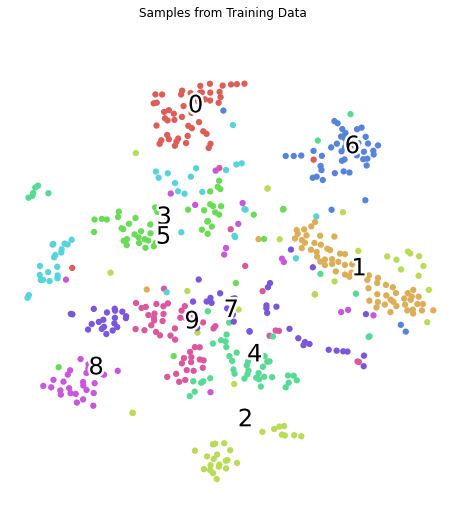

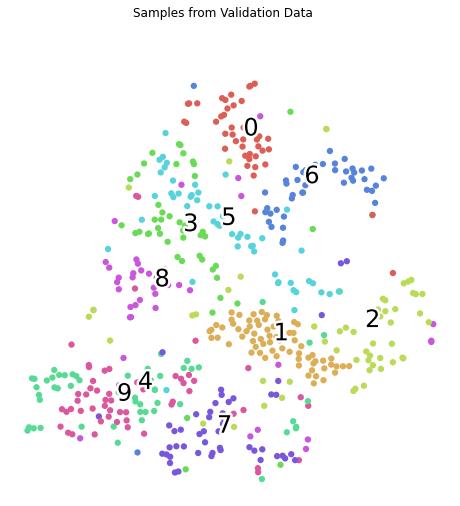

In [7]:
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(x_train_flat[:512])
scatter(train_tsne_embeds, y_train[:512], "Samples from Training Data")

eval_tsne_embeds = tsne.fit_transform(x_test_flat[:512])
scatter(eval_tsne_embeds, y_test[:512], "Samples from Validation Data")

# Generate Tripplet

In [8]:
def generate_triplet(x,y,testsize=0.3,ap_pairs=10,an_pairs=10):
    data_xy = tuple([x,y])

    trainsize = 1-testsize

    triplet_train_pairs = []
    triplet_test_pairs = []
    for data_class in sorted(set(data_xy[1])):

        same_class_idx = np.where((data_xy[1] == data_class))[0]
        diff_class_idx = np.where(data_xy[1] != data_class)[0]
        A_P_pairs = random.sample(list(permutations(same_class_idx,2)),k=ap_pairs) #Generating Anchor-Positive pairs
        Neg_idx = random.sample(list(diff_class_idx),k=an_pairs)
        

        #train
        A_P_len = len(A_P_pairs)
        Neg_len = len(Neg_idx)
        for ap in A_P_pairs[:int(A_P_len*trainsize)]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = data_xy[0][n]
                triplet_train_pairs.append([Anchor,Positive,Negative])               
        #test
        for ap in A_P_pairs[int(A_P_len*trainsize):]:
            Anchor = data_xy[0][ap[0]]
            Positive = data_xy[0][ap[1]]
            for n in Neg_idx:
                Negative = data_xy[0][n]
                triplet_test_pairs.append([Anchor,Positive,Negative])    
                
    return np.array(triplet_train_pairs), np.array(triplet_test_pairs)

In [9]:
X_train, X_test = generate_triplet(x_train_flat,y_train, ap_pairs=150, an_pairs=150,testsize=0.2)
X_train.shape, X_test.shape

((180000, 3, 784), (45000, 3, 784))

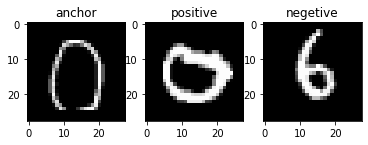

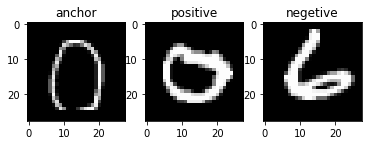

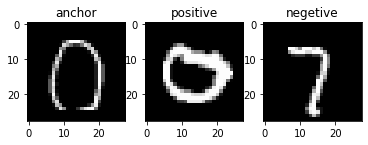

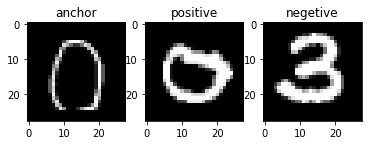

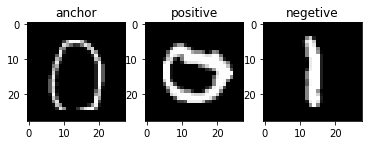

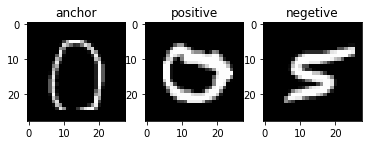

In [10]:
import copy

x=copy.deepcopy(X_train[100:106])
for i in range(len(x)):
    fig, ax =plt.subplots(1, 3)
    ax[0].imshow(x[i][0].reshape((28, 28)), cmap='gray')
    ax[0].set_title('anchor')
    ax[1].imshow(x[i][1].reshape((28, 28)), cmap='gray')
    ax[1].set_title('positive')
    ax[2].imshow(x[i][2].reshape((28, 28)), cmap='gray')
    ax[2].set_title('negetive')


# Tripplet Loss

In [11]:
import tensorflow as tf
import tensorflow.keras.backend as K

def triplet_loss(y_true, y_pred, alpha = 0.4):
    """
    Implementation of the triplet loss function
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor data
            positive -- the encodings for the positive data (similar to anchor)
            negative -- the encodings for the negative data (different from anchor)
    Returns:
    loss -- real number, value of the loss
    """
    loss = 0

    """
      Write your code here
    """
    a, p, n = tf.split(y_pred, num_or_size_splits=3, axis=1)
    dist1 = K.sqrt(K.sum(K.square(a - p), axis=-1))
    dist2 = K.sqrt(K.sum(K.square(a - n), axis=-1))
    return K.maximum(dist1 - dist2 + alpha, 0)
    # return loss

# Embedding Predictions Network

In [16]:
def embedding_pred_net(dim):
    """
    embedding predictions: Base network to be shared
    """

    """
      Write your code here
    """
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=dim))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(512))
    return model

# Siamese Network

In [17]:
anchor_in = Input((28,28,1, ), name='input-anchor')
positive_in = Input((28,28,1, ), name='input-positive')
negative_in = Input((28,28,1, ), name='input-negative')

# Shared embedding layer for positive and negative items
embedding_net = embedding_pred_net([28,28,1,])

anchor_embedding = embedding_net(anchor_in)
positive_embedding = embedding_net(positive_in)
negative_embedding = embedding_net(negative_in)

merged_vector = concatenate([anchor_embedding, positive_embedding, negative_embedding], axis=-1, name='merge')

model = Model(inputs=[anchor_in,positive_in, negative_in], outputs=merged_vector)

adam_optim = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)
model.compile(loss=triplet_loss, optimizer=adam_optim)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input-anchor (InputLayer)      [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input-positive (InputLayer)    [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 input-negative (InputLayer)    [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 sequential_1 (Sequential)      (None, 512)          1624960     ['input-anchor[0][0]',           
                                                                  'input-positive[0][0]',   

# Training

In [14]:
# preprocess shape of train and test set
shape = X_train.shape
label_train = np.zeros(shape[0])
print("labels shape", label_train.shape)
input_train = X_train.reshape(shape[0], shape[1], 28, 28)
input_train = np.swapaxes(input_train, 0, 1)
print("shape after swaping axis", input_train.shape)
input_train = list(input_train)
print("a p n list length", len(input_train))


shape = X_test.shape
label_test = np.zeros(shape[0])
input_test = X_test.reshape(shape[0], shape[1], 28, 28)
input_test = np.swapaxes(input_test, 0, 1)
print("test shape after swaping axis", input_test.shape)
input_test = list(input_test)
print("a p n list length", len(input_test))

labels shape (180000,)
shape after swaping axis (3, 180000, 28, 28)
a p n list length 3
test shape after swaping axis (3, 45000, 28, 28)
a p n list length 3


In [18]:
"""
Write your code here ...
"""
model.fit(input_train, label_train, validation_data=(input_test, label_test), batch_size=128, epochs=15)

Epoch 1/15
1407/1407 [==============================] - 39s 27ms/step - loss: 1.0770 - val_loss: 0.3836
Epoch 2/15
1407/1407 [==============================] - 38s 27ms/step - loss: 0.0845 - val_loss: 0.2508
Epoch 3/15
1407/1407 [==============================] - 38s 27ms/step - loss: 0.0301 - val_loss: 0.2754
Epoch 4/15
1407/1407 [==============================] - 37s 27ms/step - loss: 0.0159 - val_loss: 0.2212
Epoch 5/15
1407/1407 [==============================] - 37s 26ms/step - loss: 0.0091 - val_loss: 0.2081
Epoch 6/15
1407/1407 [==============================] - 38s 27ms/step - loss: 0.0077 - val_loss: 0.2186
Epoch 7/15
1407/1407 [==============================] - 38s 27ms/step - loss: 0.0066 - val_loss: 0.2223
Epoch 8/15
1407/1407 [==============================] - 37s 26ms/step - loss: 0.0053 - val_loss: 0.1837
Epoch 9/15
1407/1407 [==============================] - 37s 26ms/step - loss: 0.0050 - val_loss: 0.1561
Epoch 10/15
1407/1407 [==============================] - 38s 27m

# Visualize Data Using t-SNE

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


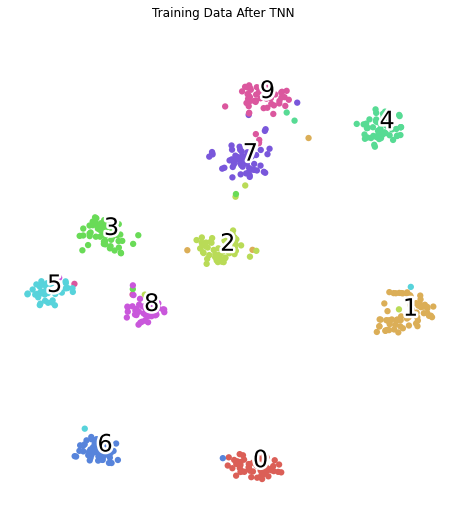

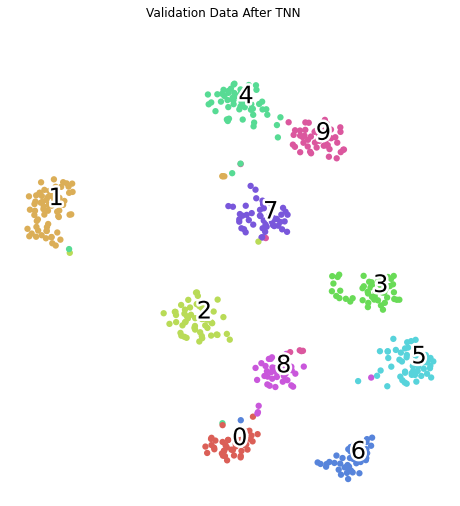

In [20]:
trained_model = Model(inputs=anchor_in, outputs=anchor_embedding)


tsne = TSNE()
X_train_trm = trained_model.predict(x_train[:512].reshape(-1,28,28,1))
X_test_trm = trained_model.predict(x_test[:512].reshape(-1,28,28,1))
train_tsne_embeds = tsne.fit_transform(X_train_trm)
eval_tsne_embeds = tsne.fit_transform(X_test_trm)
scatter(train_tsne_embeds, y_train[:512], "Training Data After TNN")
scatter(eval_tsne_embeds, y_test[:512], "Validation Data After TNN")